In [1]:
import os
import pandas as pd

dir_ = 'data'
files = [x for x in os.listdir(dir_) if x.endswith('.txt')]

experiments = [
    'heavyside_0_to_100',
    'heavyside_100_to_0_with_highBrake',
    'heavyside_100_to_0_with_highBrake2',
    'heavyside_100_to_0_with_lowBrake',
    'speedup_0_100',
    'speedup_100_200',
    'speedup_150_250',
    'test_hall_input_with_aRead',
    'test_hall_input_without_aRead'
]

groups = [
    'heavyside_0_to_100',
    'heavyside_100_to_0',
    'speedup',
    'test_hall_input'
]

In [2]:
data = []
cols = ['group', 'experiment', 'experiment_run']
for filename in files:
    name = filename.replace('.txt', '')
    # only read run #0
    if name not in experiments:
        continue
    print(f'Reading from {filename} ...', end='\r')
    df = pd.read_csv(
        os.path.join(dir_, filename),
        on_bad_lines='skip'
    )
    df['experiment'] = 'unnamed'
    df['experiment_run'] = 0
    
    print(name)
    df['group'] = ''
    
    for group in groups:
        if group in name:
            df['group'] = group
            break
        
    for exp in experiments:
        if exp in name:
            df['experiment'] = exp
            run = name.replace(exp, '').replace('_', '')
            if run != '':
                df['experiment_run'] = int(run)
            break
            
    for c in df.columns:
        if c not in cols:
            cols.append(c)
    data.append(df)

df = pd.concat([pd.DataFrame(columns=cols), *data])
df.columns = [x.replace('[', '').replace(']', '') for x in df.columns]


heavyside_0_to_100side_0_to_100.txt ...
heavyside_100_to_0_with_highBrakeith_highBrake.txt ...
heavyside_100_to_0_with_highBrake2th_highBrake2.txt ...
heavyside_100_to_0_with_lowBrakewith_lowBrake.txt ...
speedup_0_100speedup_0_100.txt ...
speedup_100_200eedup_100_200.txt ...
speedup_150_250eedup_150_250.txt ...


C:\Users\elias\AppData\Local\Temp\ipykernel_5804\1940081117.py:9: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


test_hall_input_without_aRead
test_hall_input_with_aReadut_with_aRead.txt ...


In [3]:
df['Timestamp_micros'] = pd.to_numeric(df['Timestamp_micros'], errors='coerce')
df = df.loc[~df.Timestamp_micros.isna()]
df['Timestamp'] = df['Timestamp_micros']/1e6

df[['aout_speed_uint8', 'speed_measured_hz', 'bool_brake', 'din_hall0']] = df[['aout_speed_uint8', 'speed_measured_hz', 'bool_brake', 'din_hall0']].apply(pd.to_numeric, errors='coerce')

df['Timestamp_down'] = df['Timestamp']//200e-6*200e-6

In [ ]:
df

In [ ]:
import plotly.express as px
import plotly.graph_objs as go

def line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands."""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

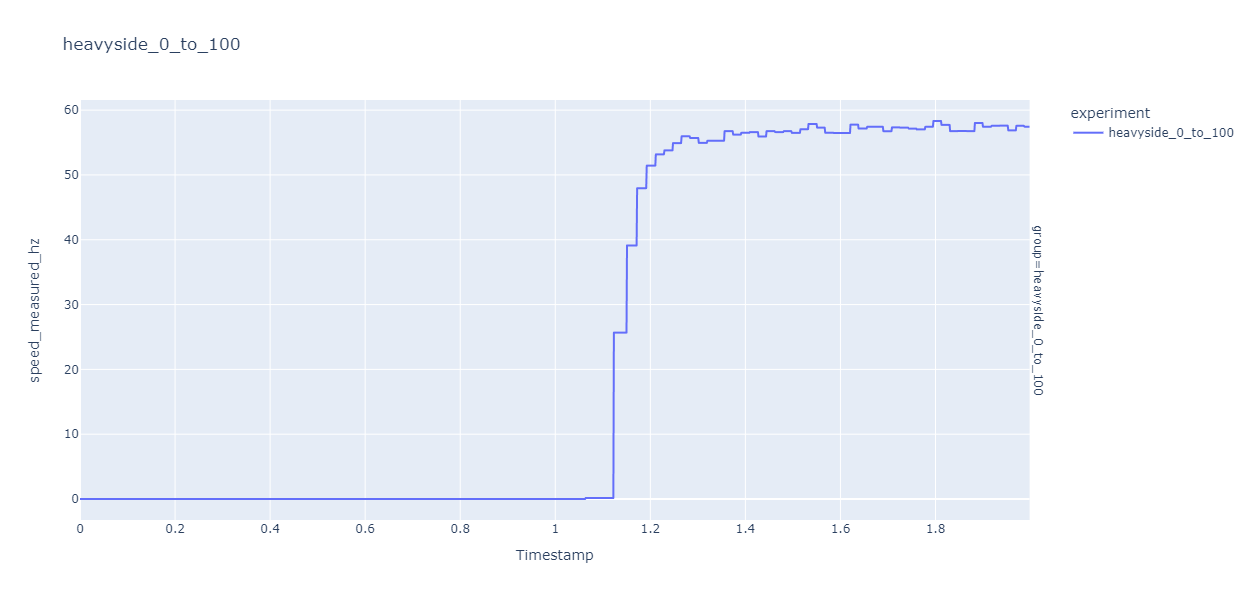

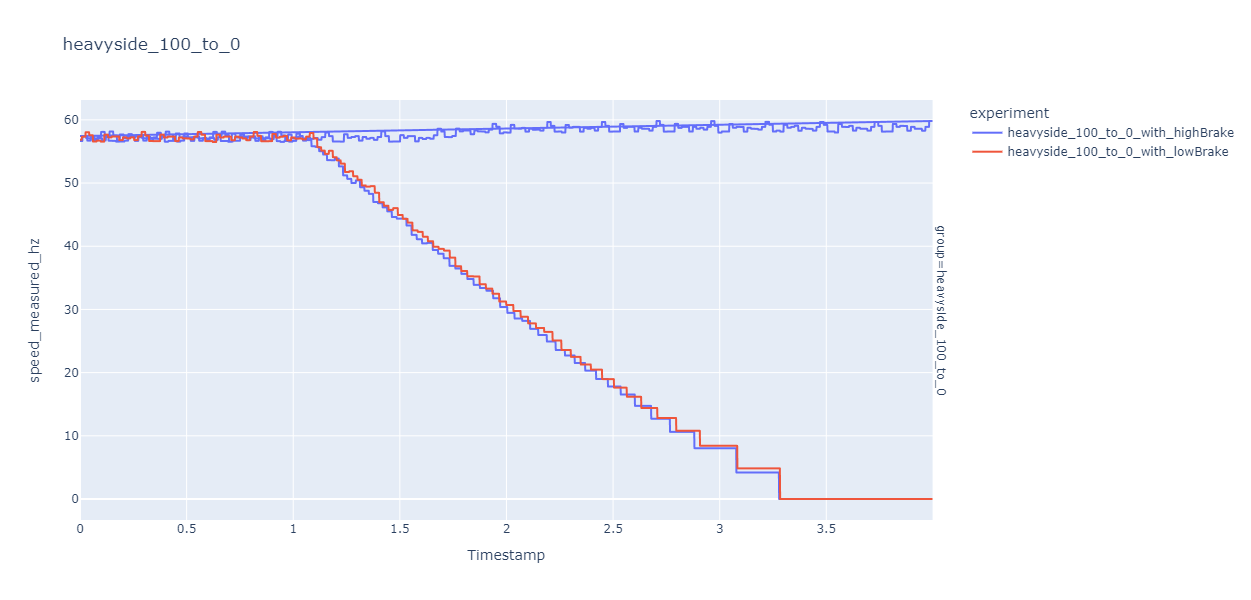

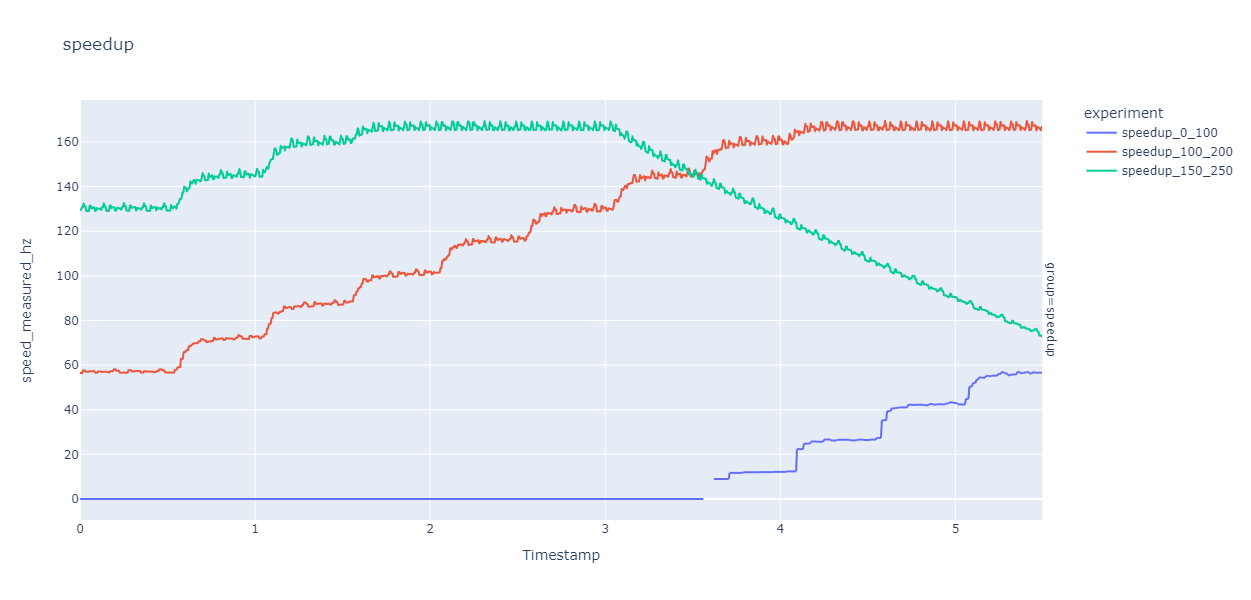

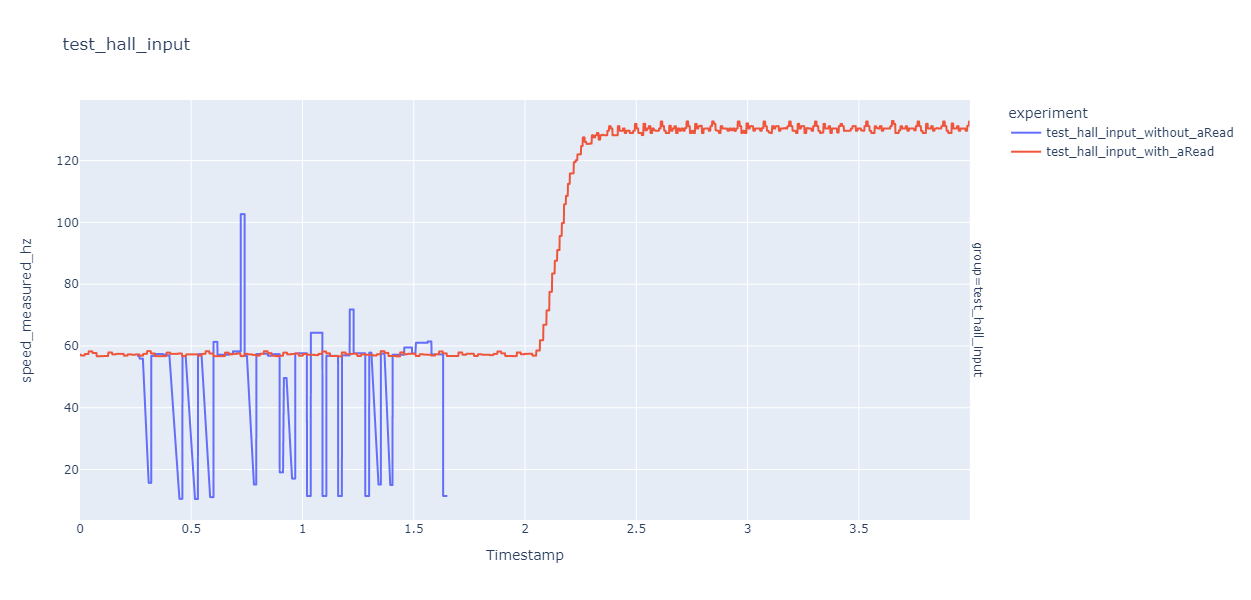

In [11]:
import plotly.express as px

for group in groups:

    fig = px.line(
        df[df.group == group][::50],
        x='Timestamp',
        y='speed_measured_hz',
        color='experiment',
        facet_row='group',
        title=group,
        height=600
    )
    fig.write_html('Measurements_'+group+'.html')
    fig.show()

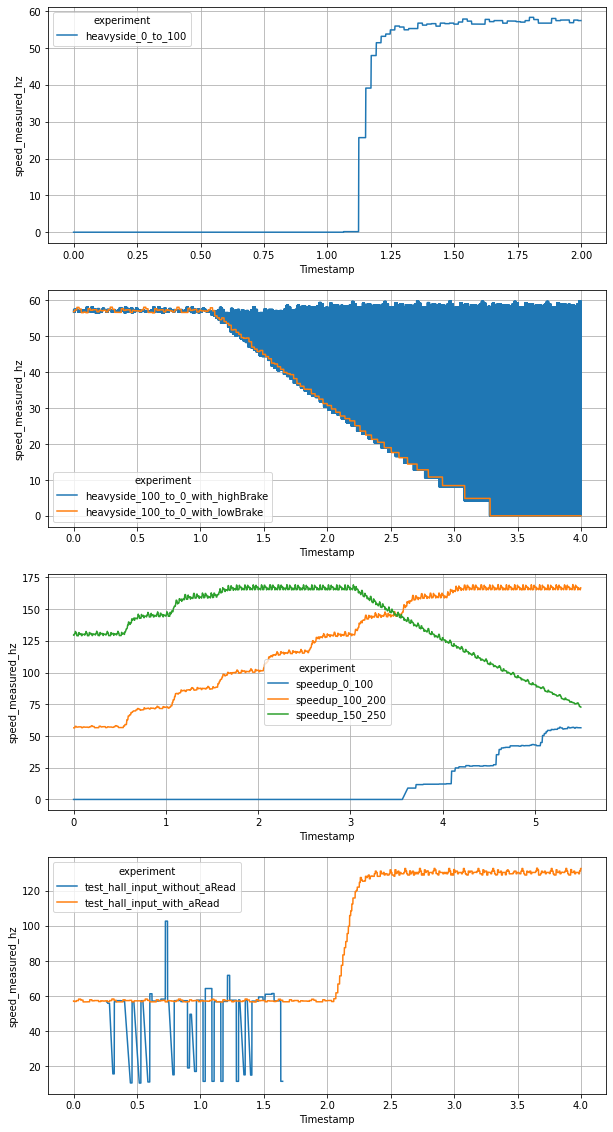

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(len(groups),1, figsize=(10, 20))

for i, group in enumerate(groups):
    sns.lineplot(
        data=df[df.group == group][::50],
        x='Timestamp',
        y='speed_measured_hz',
        hue='experiment',
        ax=axs[i]
        #height=900
    )
    axs[i].grid(True)
plt.savefig('Messungen_Run0.png')